In [26]:
# Generic libraries
import time
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
import tqdm
import math
import seaborn as sns
import matplotlib

%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.context('seaborn')
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.pylabtools import figsize
from collections import namedtuple
from tabulate import tabulate
from IPython.display import Latex
from IPython.display import HTML
from matplotlib import rc


In [2]:
## autocorrelation estimate
def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    #r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]) #slow method using the definition
    r = np.correlate(x, x, mode = 'full')[-n:] # fast method, same result!
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [20]:
## plot settings
plt.style.use('seaborn-deep')
heat_cmap = 'viridis'
matplotlib.rcParams["axes.formatter.useoffset"] = False

In [34]:
# check these are matched
path = "../data/04-prod/thermo/"
plotpath = "../plots/thermo/"
output_name = "prod_"


In [35]:
# load all necessary equilibration info
E = pd.read_csv(path+'tot_energy.xvg', delimiter = '  ', skiprows=24)
U = pd.read_csv(path+'pot_energy.xvg', delimiter = '  ', skiprows=24)
H = pd.read_csv(path+'enthalpy.xvg', delimiter = '  ', skiprows=24)
T = pd.read_csv(path+'temp.xvg', delimiter = '  ', skiprows=24)
d = pd.read_csv(path+'density.xvg', delimiter = '  ', skiprows=24)


E['t [ns]'] = E['t']/1000 # switch to ns 
U['t [ns]'] = U['t']/1000
H['t [ns]'] = H['t']/1000
T['t [ns]'] = T['t']/1000
d['t [ns]'] = d['t']/1000

nframes = len(E)
dt = 2500*0.002 #nstenergy*dt
time = np.arange(0, dt*nframes, dt)
t_ns = time / 1000
print(nframes, 'frames')
print(t_ns[-1], 'ns')


/home/kryohi/.miniconda3/envs/mdanal/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


92212 frames
461.055 ns


In [36]:
from scipy.ndimage.filters import uniform_filter1d


<IPython.core.display.Javascript object>


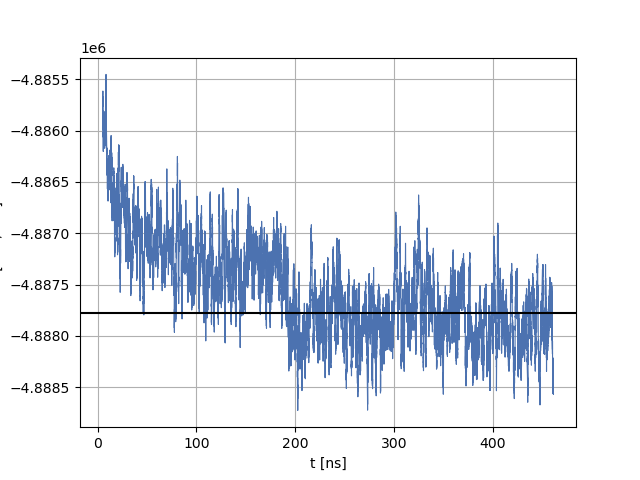

In [38]:
fig = plt.figure()
mean = (E["E"][31200:-1]).mean()
#print('Emean =', mean)
plt.plot(E['t [ns]'][1000:-1], uniform_filter1d(E['E'][1000:-1], size=200), lw=0.8)
#ax = E.plot(x='t [ns]', y=' E', lw=0.8)
plt.axhline(mean, color='black', label="TOTAL mean")
plt.xlabel("t [ns]")
plt.ylabel("E [kcal/mol]")
plt.grid()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'totenergy.pdf'))

<IPython.core.display.Javascript object>


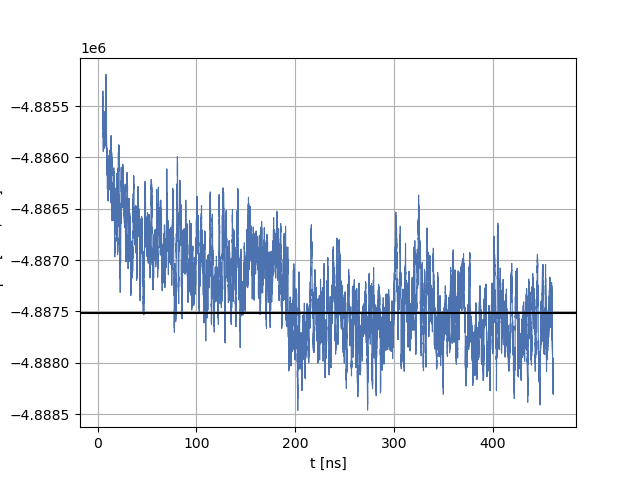

In [39]:
fig = plt.figure()
mean = (H["H"][31200:-1]).mean()
#print('Emean =', mean)
plt.plot(H['t [ns]'][1000:-1], uniform_filter1d(H['H'][1000:-1], size=200), lw=0.8)
#ax = E.plot(x='t [ns]', y=' E', lw=0.8)
plt.axhline(mean, color='black', label="TOTAL mean")
plt.xlabel("t [ns]")
plt.ylabel("Epot [kcal/mol]")
plt.grid()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'enthalpy.pdf'))

<IPython.core.display.Javascript object>


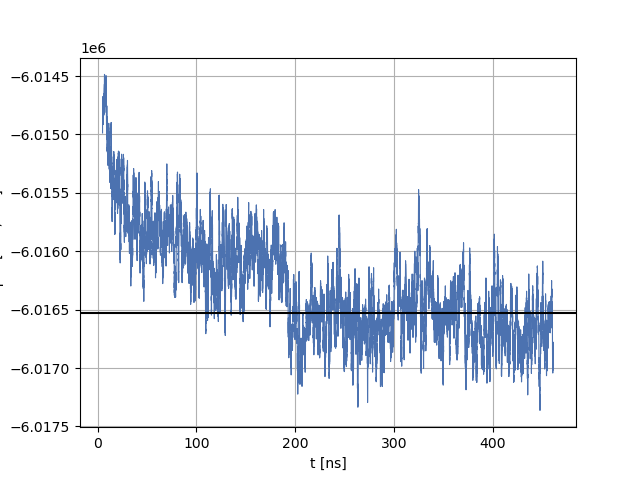

In [42]:
fig = plt.figure()
mean = (U["U"][31200:-1]).mean()
#print('Emean =', mean)
plt.plot(U['t [ns]'][1000:-1], uniform_filter1d(U['U'][1000:-1], size=200), lw=0.8)
#ax = E.plot(x='t [ns]', y=' E', lw=0.8)
plt.axhline(mean, color='black', label="TOTAL mean")
plt.xlabel("t [ns]")
plt.ylabel("Epot [kcal/mol]")
plt.grid()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'potenergy.pdf'))

<IPython.core.display.Javascript object>


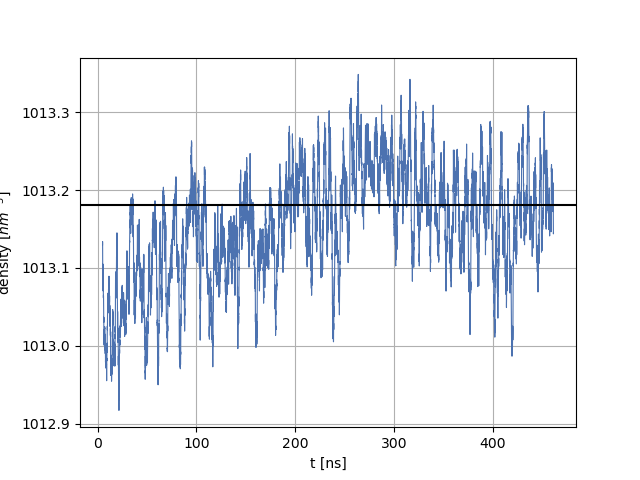

In [47]:
fig = plt.figure()
mean = (d["d"][31200:-1]).mean()
#print('Emean =', mean)
plt.plot(d['t [ns]'][1000:-2:5], uniform_filter1d(d['d'][1000:-1], size=400)[0:-1:5], lw=0.8)
#ax = E.plot(x='t [ns]', y=' E', lw=0.8)
plt.axhline(mean, color='black', label="TOTAL mean")
plt.xlabel("t [ns]")
plt.ylabel(r"density [$nm^{-3}$]")
plt.grid()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'density.pdf'))

In [48]:
## autocorrelation estimate for box-averaging
def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    #r = np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]) #slow method using the definition
    r = np.correlate(x, x, mode = 'full')[-n:] # fast method, same result!
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

<IPython.core.display.Javascript object>


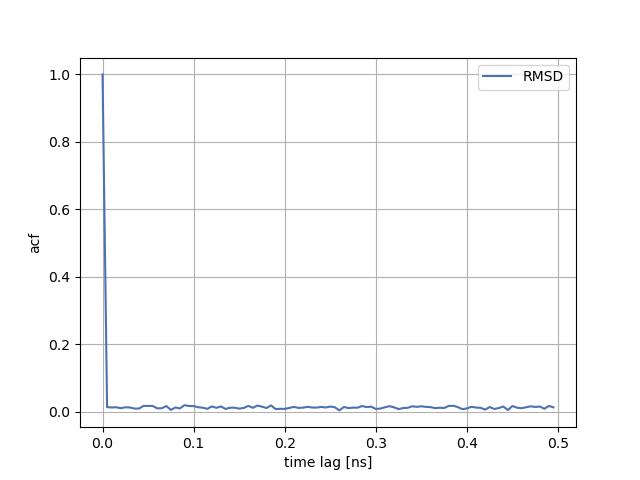

In [49]:
start = 1000
t_acf = H['t [ns]'][0:-start]
acf = autocorrelation(H['H'][start:-1])[0:len(t_acf)//2]

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t_acf[0:100], acf[0:100], label=r"RMSD")
plt.xlabel("time lag [ns]")
plt.ylabel("acf")
plt.grid()
plt.legend()
plt.show()
plt.savefig(os.path.join(plotpath, output_name+'enthalpy_acf.pdf'))

In [46]:
def blocked(array, blocklength, startframe):
    #size = (universe.trajectory.n_frames - startframe) // nblocks
    nblocks = math.floor((nframes - startframe) / blocklength)
    blocks_avg = []
    blocks_std = []
    
    for block in range(nblocks):
        blocks_avg.append(np.average(array[startframe+block*blocklength : startframe+(block+1)*blocklength]))
        blocks_std.append(np.std(array[startframe+block*blocklength : startframe+(block+1)*blocklength]))
    blockaverage = np.average(blocks_avg)
    blockstd = np.std(blocks_avg) #/  math.sqrt(nblocks)
    #blockstd = np.average(blocks_std)

    return nblocks, blocklength, blockaverage, blockstd


In [32]:
startframe = 1000
#nblocks_array = [60,70,80,100,150,220,300,400,595,836,1045,1393,2090]
block_lengths = [2,3,4,5,7,8,10,15,20,25,30,40,50,60,70,80,100,120]
results = []
for blocks in block_lengths:
    results.append(blocked(U, blocks, startframe))
E_blockanal = np.array(results)

<IPython.core.display.Javascript object>


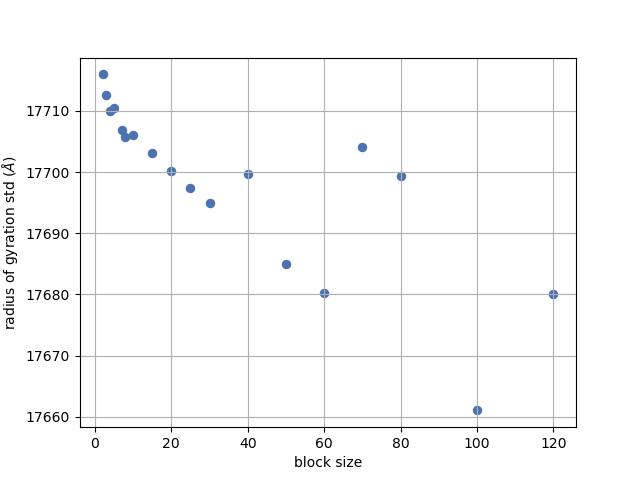

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(block_lengths, E_blockanal[:,3], lw=0.8, label=r"$R_G$")
ax.set_xlabel("block size")
ax.set_ylabel(r"radius of gyration std ($\AA$)")
plt.grid()
plt.show()


<IPython.core.display.Javascript object>


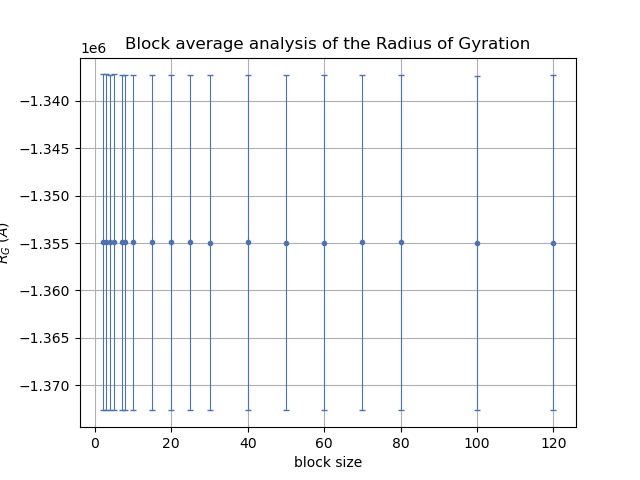

UsageError: Line magic function `%plt.savefig(os.path.join(plotpath,` not found.


In [30]:
fig = plt.figure()
ax = plt.subplot(111)
ax.errorbar(block_lengths, E_blockanal[:,2], E_blockanal[:,3], lw=0.8, marker='.', label=r"$RMSD$", capsize=2.5, linestyle='')
ax.set_xlabel("block size")
ax.set_ylabel(r"$R_G$ ($\AA$)")
plt.title("Block average analysis of the ")
plt.grid()
plt.show()
#plt.savefig(os.path.join(plotpath, output_name+'rgyr_block_fixed.pdf'))